**In this tutorial you'll**:

1. **Learn what Stim is.**
2. **Install the Stim python package.**
3. **Create a simple circuit, and sample from it.**
4. **Add detector annotations to a circuit, and sample them.**
5. **Generate example error correction circuits.**
6. **Combine Stim with PyMatching to correct the errors in a circuit.**
7. **Estimate the threshold of an error correcting code.**

**Prereqs**:

This tutorial assumes you can read and write Python code, and have a working Python 3 environment.

This tutorial assumes you are comfortable with quantum stabilizer circuits (circuits with Clifford operations and Pauli measurements). For example, it assumes you know that stabilizer circuits can represent protocols like error correction and that it's possible to simulate them cheaply.

This tutorial assumes you are a *little* familiar with quantum error correcting codes. For example, it assumes you know that the surface code is a well known code and that a common task is to estimate the threshold of a code.

# 1. What is Stim?

[Stim is an open source tool](https://github.com/quantumlib/Stim) for high performance analysis and simulation of quantum stabilizer circuits, intended to help with research into quantum error correcting codes.

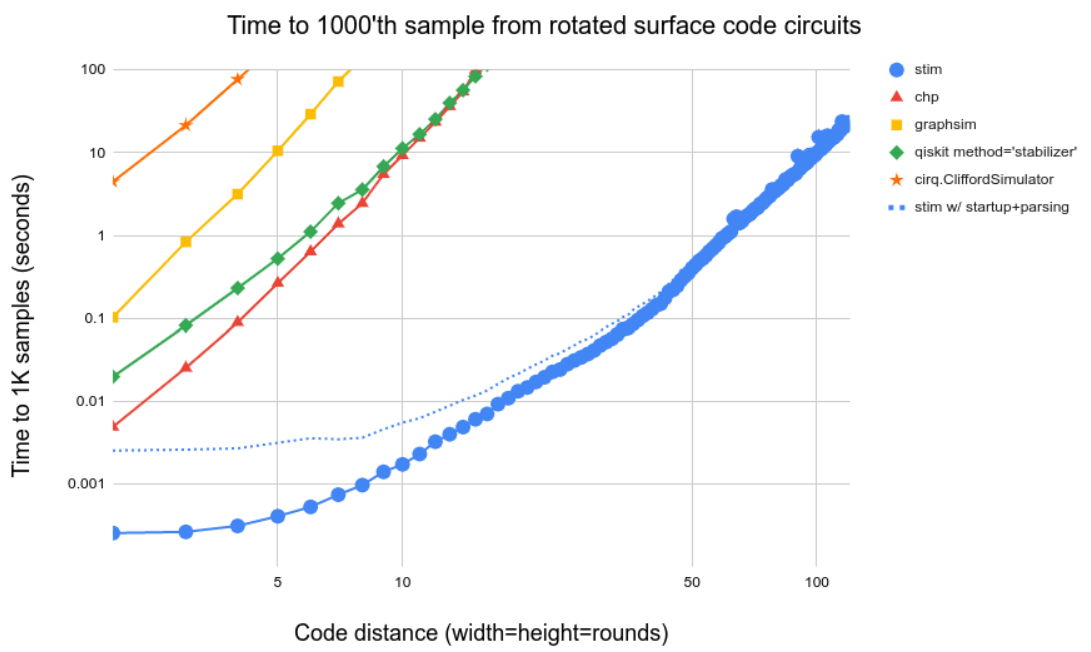

See also: [the paper describing Stim published in Quantum](https://quantum-journal.org/papers/q-2021-07-06-497/).

See also: [a 15 minute lightning talk presenting Stim at QPL2021](https://youtu.be/7m_JrJIskPM?t=895).

# 2. Install the Stim python package.

The first thing to do is to install and import stim.
Thanks to the python ecosystem, this is easy!
Stim is available as a pypi package, and can be installed using `pip install stim` and then imported with `import stim`.
Just like any other python package.

It may take a few minutes to install Stim the first time you do it, because Stim is a C++ python extension compiled locally for maximum performance.
C++ has legendarily awful compile times.

In [1]:
!pip install stim

In [2]:
import stim

# 3. Create a simple circuit, and sample from it.

In Stim, circuits are instances of the `stim.Circuit` class. You create a new empty circuit with `stim.Circuit()`, and add operations to it by calling `append_operation(name_of_gate, list_of_targets)`.

You can find the name of the gate you want from the [stim gates reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md). Most of them are what you'd expect, like "H" for the Hadamard gate. Targets are usually just a number indicating a qubit. There's a qubit `0`, a qubit `1`, etc.

The first circuit you'll make is a circuit that prepares a Bell pair and then measures it:

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append_operation("H", [0])
circuit.append_operation("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append_operation("M", [0, 1])

# Let's see the circuit's representation using stim's circuit language:
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')


You can sample from the circuit using the `circuit.compile_sampler()` method to get a sampler object, and then calling `sample` on that object. For large circuits (thousands of qubits, millions of operations), it may take a few seconds to create the sampler (because it involves performing a stabilizer tableau simulation of the circuit to get a reference sample). Once the reference sample is acquired, the sampler is returned and samples can be acquired in bulk very cheapy.

Try taking 10 shots from the circuit:

In [4]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


Notice how there are ten rows (because you took ten shots) with two results per row (because there were two measurements in the circuit).
Also notice how the results are random from row to row, but always agree within each row.
That makes sense; that's what's supposed to happen when you repeatedly prepare and measure the |00> + |11> state.

# 4. Add detector annotations to a circuit, and sample them.

Stim circuits can include error correction annotations.
In particular, you can annotate that certain sets of measurements can be used to detect errors.
For example, in the circuit you created above, the two measurement results should always be equal.
You can tell Stim you care about that by adding a `DETECTOR` annotation to the circuit.

The `DETECTOR` annotation will take two targets: the two measurements whose parity you are asserting should be consistent from run to run. You point at the measurements by using the `stim.target_rec` method (short for "target measurement record"). The most recent measurement is `stim.target_rec(-1)` (also known as `rec[-1]` in stim's circuit language), and the second most recent measurement is `stim.target_rec(-2)`:

In [5]:
# Indicate the two previous measurements are supposed to consistently agree.
circuit.append_operation("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


A slightly subtle point about detectors is that they *only* assert the parity is *consistent*.
A detector *doesn't say what the parity should be*.
You annotate that a pair of measurements is always different in the same way that you annotate that a pair of measurements is always the same; it's the *consistency* that's key.

Anyways, now that you've annotated the circuit with a detector, you can sample from the circuit's detectors instead of sampling from its measurements.
You do that by creating a detector sampler, using the `compile_detector_sampler` method, and then calling `sample` on it.

In [6]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[0]
 [0]
 [0]
 [0]
 [0]]


There are 5 rows in the results, because you took 5 shots.
There's one entry per row, because you put one detector in the circuit.

Notice how the results are always 0.
The detector is never producing a detection event.
That's because there's no noise in the circuit; nothing to disturb the peace and quiet of a perfectly working machine.
Well... time to fix that!

You should adjust the circuit so that it *does* have noise.
Stim has a variety of error channels to pick from, like single qubit depolarization (`DEPOLARIZE1`) and phase damping (`Z_ERROR`), but in this content you should use `X_ERROR`.
The `X_ERROR` noise channel independently applies a Pauli X error, with a given probability, to each of its targets.

One place where Stim is lacking, as of this writing, is the ability to make random access changes to circuits (e.g. replacing individual instructions or inserting instructions in the center of a circuit). To work around this, you can just redefine the circuit from scratch with the noise inserted using Stim's domain specific language for circuits:

In [7]:
circuit = stim.Circuit("""
    H 0
    CX 0 1
    X_ERROR(0.2) 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

Now that you've put noise before the measurements, try sampling some more detector shots and see what happens:

In [8]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


It's no longer all zeroes (...unless you got pretty lucky).
There are 1s appearing amongst the 0s.

The *detection fraction* of the circuit is how often detectors fire on average.
Given that an X error is being applied to each qubit with 20% probability, and the detector will fire when one of the qubits is hit (but not both), the detection fraction should be $0.8 \cdot 0.2 \cdot 2 = 0.32$.

You can estimate the detection fraction by just taking a lot of shots, and dividing by the number of shots and the number of detectors:

In [9]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.320086


As you can see, the directly estimate value is close to the expected value $0.32$.

# 5. Generate example error correction circuits.

Now it's time for you to work with a *real* error correcting circuit.
Well... a classical error correcting circuit.
The repetition code.

You could generate a repetition code circuit for yourself, but for the purposes of this tutorial it's easiest to use the example one included with Stim.
You can do this by calling `stim.Circuit.generated` with an argument of `"repetition_code:memory"`.
(You can find other valid arguments in the method's doc string, or just by passing in a bad one and looking at the exception message that comes out.)

Stim takes a few different parameters when generating circuits.
You have to decide how many times the stabilizers of the code are measured by specifying `rounds`, you have to decide the code distance by specifying `distance`, and you can specify what kind of noise to include using a few optional parameters.

To start with, you should just set `before_round_data_depolarization=0.03` which will insert a `DEPOLARIZE1(0.03)` operation targeting every data qubit at the start of each round of measuring the stabilizers of the code.
This is a "phenomenological noise model":

In [10]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.03)
print(repr(circuit))

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
    TICK
    DEPOLARIZE1(0.03) 0 2 4 6 8 10 12 14 16 18
    CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15 18 17
    TICK
    MR 1 3 5 7 9 11 13 15 17
    DETECTOR(1, 0) rec[-9]
    DETECTOR(3, 0) rec[-8]
    DETECTOR(5, 0) rec[-7]
    DETECTOR(7, 0) rec[-6]
    DETECTOR(9, 0) rec[-5]
    DETECTOR(11, 0) rec[-4]
    DETECTOR(13, 0) rec[-3]
    DETECTOR(15, 0) rec[-2]
    DETECTOR(17, 0) rec[-1]
    REPEAT 99 {
        TICK
        DEPOLARIZE1(0.03) 0 2 4 6 8 10 12 14 16 18
        CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15 18 17
        TICK
        MR 1 3 5 7 9 11 13 15 17
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-9] rec[-18]
        DETECTOR(3, 0) rec[-8] rec[-17]
        DETECTOR(5, 0) rec[-7] rec[-16]
        DETECTOR(7, 0) rec[-6] rec[-15]
        DETECTOR(9, 0) rec[-5] rec[-14]


The circuits generated by Stim include a lot of "nice to have" features.
Of course it annotates the measurements to compare (as `DETECTOR`s), but the `DETECTOR` instructions also include optional space and time coordinates (which have no effect but could be useful when debugging or drawing the circuit).
The circuit also has `TICK` annotations indicating divisions between layers of gates in the circuit, a `REPEAT` block to avoid restating the same ten operations a hundred times, and an `OBSERVABLE_INCLUDE` instruction identifying the measurement corresponding to the logical value preserved by the circuit.
(Normally observables are the parity of many measurements, but the repetition code is very simple so it's just one measurement.)
(The `0` in `OBSERVABLE_INCLUDE(0)` is identifying which observable value the measurement is being included in.)

With the circuit in hand, you can try sampling from it.
Try sampling the measurements once, and printing out the results split up just right so that time advances from line to line:

In [11]:
sampler = circuit.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 9):
    timeslice = one_sample[k:k+9]
    print("".join("_1"[e] for e in timeslice))

_________
_______11
_______11
11_____11
11_____11
11_____11
11_____11
11_____11
11__11_11
_1__11_11
_1__11_11
_1__11_11
_1__11_11
_1__11_11
_1__11_11
_1__11_11
_1__11_11
_1_____11
_111___11
_111___11
_111___11
_111___11
_111___11
___1___11
___1___11
___1___11
___1___11
___1___11
___1___11
___1___11
___1___11
___1___11
___1___11
___1_____
___1_____
___1_____
___1_____
___1_____
___1_____
___1_____
___1_____
___1_____
___1_____
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_11__
___1_1111
___1_1111
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
___1_111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_
__1__111_


See how the 1s seem to come in pairs of streaks?
That's because once a data qubit is flipped it stays flipped, and the measurements to its left and right permanently change parity.

If you sample the circuit's detectors, instead of its measurements, the streaks are replaced by spackle.
You get much sparser data:

In [12]:
detector_sampler = circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 9):
    timeslice = one_sample[k:k+9]
    print("".join("_1"[e] for e in timeslice))

_________
_________
_________
_________
_________
_________
_________
_________
_________
_____11__
_________
_________
_________
__11_____
_________
_____11__
______11_
_________
_________
_________
_________
_________
_11______
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
____11___
_________
_________
_________
_________
_________
_________
_____11__
_________
_________
_________
_________
_________
1__11____
_________
_________
_________
_________
_________
_______11
_1111____
_________
_11______
_________
_________
_________
_________
_________
_______11
_________
_________
_________
_________
__11_____
11_11____
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
_________
__11_____
__11_____
_________
_________
_________
_________
11____11_
_________
11______1
111______
_________
_________
_________
_________


Notice how the 1s tend to come in pairs, except near the sides.
Note that the logical observable is annotated to be a measurement of the leftmost data qubit.
The number of 1s that match to the left boundary tells you how many times that data qubit was flipped.
If you just had a syndrome decoder, you could use it to solve the matching problem and figure out if the leftmost data qubit was flipped and odd number of times or not...

# 6. Combine Stim with PyMatching to correct the errors in a circuit.

Stim has a key feature that makes it easier to use a decoder: converting a circuit into a detector error model.
A detector error model is just a list of all the independent error mechanisms in a circuit, as well as their symptoms (which detectors they set off) and frame changes (which logical observables they flip).

You can get the detector error mode for a circuit by calling `circuit.detector_error_model()`:

In [13]:
print(repr(circuit.detector_error_model()))

stim.DetectorErrorModel('''
    error(0.02) D0
    error(0.02) D0 D1
    error(0.02) D1 D2
    error(0.02) D2 D3
    error(0.02) D3 D4
    error(0.02) D4 D5
    error(0.02) D5 D6
    error(0.02) D6 D7
    error(0.02) D7 D8
    error(0.02) D8 L0
    detector(1, 0) D0
    detector(3, 0) D1
    detector(5, 0) D2
    detector(7, 0) D3
    detector(9, 0) D4
    detector(11, 0) D5
    detector(13, 0) D6
    detector(15, 0) D7
    detector(17, 0) D8
    repeat 98 {
        error(0.02) D9
        error(0.02) D9 D10
        error(0.02) D10 D11
        error(0.02) D11 D12
        error(0.02) D12 D13
        error(0.02) D13 D14
        error(0.02) D14 D15
        error(0.02) D15 D16
        error(0.02) D16 D17
        error(0.02) D17 L0
        shift_detectors(0, 1) 0
        detector(1, 0) D9
        detector(3, 0) D10
        detector(5, 0) D11
        detector(7, 0) D12
        detector(9, 0) D13
        detector(11, 0) D14
        detector(13, 0) D15
        detector(15, 0) D16
        detect

This format is easier for decoders to consume than a raw circuit, because everything is explained in terms of observable symptoms and hidden symptoms, which is how decoders usually conceptualize of the problem space.

To use this error model with a decoder, you need a decoder that can consume this format.
Unfortunately, there aren't a lot of those.
You will probably need to write custom glue code to configure a decoder using this format.
You probably don't want this tutorial to get sidetracked into the details of writing glue code, so how about just borrowing some open source Apache 2 licensed code from https://github.com/strilanc/honeycomb_threshold that glues Stim to [PyMatching](https://github.com/oscarhiggott/PyMatching)?

Honestly, unless you're really interested in the details of glueing two pieces of software together, you should probably just scroll past this next block of code.
It's better than having to work from the raw circuit, but it's still a pain point.
Of course, feel free to use parts of this code for glueing to your own decoder if needed.

In [14]:
!pip install pymatching

In [15]:
##########################################################
#################### BEGIN GLUE CODE #####################
##########################################################

import math
import networkx as nx
import pymatching
from typing import Callable, List


def predict_observable_errors_using_pymatching(circuit: stim.Circuit,
                                               det_samples: np.ndarray,
                                               ) -> np.ndarray:
    """Turn detection events into predicted observable errors."""
    error_model = circuit.detector_error_model(decompose_errors=True)
    matching_graph = detector_error_model_to_pymatching_graph(error_model)

    num_shots = det_samples.shape[0]
    num_obs = circuit.num_observables
    num_dets = circuit.num_detectors
    assert det_samples.shape[1] == num_dets

    predictions = np.zeros(shape=(num_shots, num_obs), dtype=np.bool8)
    for k in range(num_shots):
        expanded_det = np.resize(det_samples[k], num_dets + 1)
        expanded_det[-1] = 0
        predictions[k] = matching_graph.decode(expanded_det)
    return predictions


def detector_error_model_to_pymatching_graph(model: stim.DetectorErrorModel) -> pymatching.Matching:
    """Convert a stim error model into a pymatching graph."""
    g = detector_error_model_to_nx_graph(model)
    num_detectors = model.num_detectors
    num_observables = model.num_observables

    # Add spandrels to the graph to ensure pymatching will accept it.
    # - Make sure there's only one connected component.
    # - Make sure no detector nodes are skipped.
    # - Make sure no observable nodes are skipped.
    for k in range(num_detectors):
        g.add_node(k)
    g.add_node(num_detectors + 1)
    for k in range(num_detectors + 1):
        g.add_edge(k, num_detectors + 1, weight=9999999999)
    g.add_edge(num_detectors, num_detectors + 1, weight=9999999999, qubit_id=list(range(num_observables)))

    return pymatching.Matching(g)


def detector_error_model_to_nx_graph(model: stim.DetectorErrorModel) -> nx.Graph:
    """Convert a stim error model into a NetworkX graph."""

    g = nx.Graph()
    boundary_node = model.num_detectors
    g.add_node(boundary_node, is_boundary=True, coords=[-1, -1, -1])

    def handle_error(p: float, dets: List[int], frame_changes: List[int]):
        if p == 0:
            return
        if len(dets) == 0:
            # No symptoms for this error.
            # Code probably has distance 1.
            # Accept it and keep going, though of course decoding will probably perform terribly.
            return
        if len(dets) == 1:
            dets = [dets[0], boundary_node]
        if len(dets) > 2:
            raise NotImplementedError(
                f"Error with more than 2 symptoms can't become an edge or boundary edge: {dets!r}.")
        if g.has_edge(*dets):
            edge_data = g.get_edge_data(*dets)
            old_p = edge_data["error_probability"]
            old_frame_changes = edge_data["qubit_id"]
            # If frame changes differ, the code has distance 2; just keep whichever was first.
            if set(old_frame_changes) == set(frame_changes):
                p = p * (1 - old_p) + old_p * (1 - p)
                g.remove_edge(*dets)
        g.add_edge(*dets, weight=math.log((1 - p) / p), qubit_id=frame_changes, error_probability=p)

    def handle_detector_coords(detector: int, coords: np.ndarray):
        g.add_node(detector, coords=coords)

    eval_model(model, handle_error, handle_detector_coords)

    return g


def eval_model(
        model: stim.DetectorErrorModel,
        handle_error: Callable[[float, List[int], List[int]], None],
        handle_detector_coords: Callable[[int, np.ndarray], None]):
    """Interprets the error model instructions, taking care of loops and shifts.

    Makes callbacks as error mechanisms are declared, and also when detector
    coordinate data is declared.
    """
    det_offset = 0
    coords_offset = np.zeros(100, dtype=np.float64)

    def _helper(m: stim.DetectorErrorModel, reps: int):
        nonlocal det_offset
        nonlocal coords_offset
        for _ in range(reps):
            for instruction in m:
                if isinstance(instruction, stim.DemRepeatBlock):
                    _helper(instruction.body_copy(), instruction.repeat_count)
                elif isinstance(instruction, stim.DemInstruction):
                    if instruction.type == "error":
                        dets: List[int] = []
                        frames: List[int] = []
                        t: stim.DemTarget
                        p = instruction.args_copy()[0]
                        for t in instruction.targets_copy():
                            if t.is_relative_detector_id():
                                dets.append(t.val + det_offset)
                            elif t.is_logical_observable_id():
                                frames.append(t.val)
                            elif t.is_separator():
                                # Treat each component of a decomposed error as an independent error.
                                # (Ideally we could configure some sort of correlated analysis; oh well.)
                                handle_error(p, dets, frames)
                                frames = []
                                dets = []
                        # Handle last component.
                        handle_error(p, dets, frames)
                    elif instruction.type == "shift_detectors":
                        det_offset += instruction.targets_copy()[0]
                        a = np.array(instruction.args_copy())
                        coords_offset[:len(a)] += a
                    elif instruction.type == "detector":
                        a = np.array(instruction.args_copy())
                        for t in instruction.targets_copy():
                            handle_detector_coords(t.val + det_offset, a + coords_offset[:len(a)])
                    elif instruction.type == "logical_observable":
                        pass
                    else:
                        raise NotImplementedError()
                else:
                    raise NotImplementedError()
    _helper(model, 1)

##########################################################
##################### END GLUE CODE ######################
##########################################################

A notable detail about this glue code is that it calls `circuit.detector_error_model(decompose_errors=True)` on the circuit you give it, instead of just `circuit.detector_error_model()`.
Specifying `decompose_errors=True` tells Stim it has to output a graph-like error model, where errors are decomposed into pieces with exactly 2 detection events (edges) or exactly 1 detection event (boundary edges).
This won't work on all circuits; for example it won't work on a color code circuit.
But it does work on repetition codes and surface codes.

With your glue code in hand, you can make the decoder attempt to predict whether or not the logical observable have been flipped, given the observed detection events.

To do this, you need to sample the circuit's detectors with `append_observables=True` specified. This will sample whether or not each declared observable was flipped in addition to the usual detector samples, and put the observable flipped data after the end of the detector data.
You can then split the shots into the detector part and the observable part, feed the detector part to the decoder, and check whether its prediction of whether the observables were flipped matches the held back ground truth of whether the observables were flipped.

You can write a method for doing this to an arbitrary circuit:

In [16]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    shots = circuit.compile_detector_sampler().sample(num_shots, append_observables=True)

    detector_parts = shots[:, :circuit.num_detectors]
    actual_observable_parts = shots[:, circuit.num_detectors:]
    predicted_observable_parts = predict_observable_errors_using_pymatching(circuit, detector_parts)

    num_errors = 0
    for actual, predicted in zip(actual_observable_parts, predicted_observable_parts):
        if not np.array_equal(actual, predicted):
            num_errors += 1
    return num_errors


And then try it on your repetition code circuit:

In [17]:
circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
num_shots = 1000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("logical_error_rate at 3%:", num_logical_errors / num_shots)

logical_error_rate at 3%: 0.0


Contrast this smooth sailing with what you get from doing no error correction, and just assuming that the logical observable is correct:

In [18]:
num_naive_logical_errors = np.sum(circuit.compile_detector_sampler().sample(shots=num_shots, append_observables=True)[:, -1])
print("naive logical error rate at 3%:", num_naive_logical_errors / num_shots)

naive logical error rate at 3%: 0.494


Wow, the correction is working a whole lot better than the naive approach.
Actually, with the physical error rate so low, the correction is almost working *too* well.
There's a decent chance you didn't see any logical errors at all!

It's not very interesting for things to *always* work.
You should try bumping the physical error rate up from 3% to 13%:

In [19]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.13)
num_shots = 1000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("logical_error_rate at 13%:", num_logical_errors / num_shots)

logical_error_rate at 13%: 0.052


Ah. The existence of failure. Perfect.

# 7. Estimate the threshold of an error correcting code.

Estimating the threshold of an error correcting code really just comes down to trying a bunch of physical error rates and code distances.
You plot out the logical error rate vs physical error rate curve for each distance, and see where the curves cross.
That's where the physical error rate gets bad enough that increasing the distance starts to make the logical error rate worse, instead of better.
That's the threshold physical error rate.

Decoding so many cases might take a minute to run, but once it's done you can find the threshold just by looking for where the lines touch.

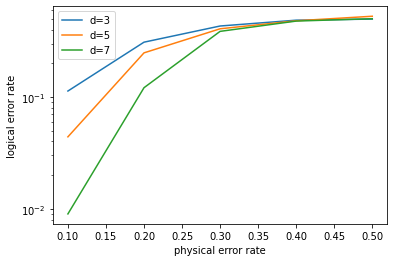

In [20]:
import matplotlib.pyplot as plt

num_shots = 1000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        xs.append(noise)
        ys.append(count_logical_errors(circuit, num_shots) / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.semilogy()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.legend()
plt.show()

From the results here you can see that the repetition code has an amazingly high threshold! Somewhere around 30%-40%. Well... it's not *quite* so amazing when you remember that you're using a phenomenological noise model (instead of a circuit level noise model) and also that you're inserting depolarizing errors instead of bit flip errors (the repetition code is immune to Z errors, and when a depolarizing error occurs it's a Z error one third of the time).

Still, you can see that it's not so hard to try a few different cases and look for where lines cross.

Now that you know the basic workflow, you should do another threshold estimate.
A proper *quantum* threshold estimate, using a quantum error correcting code instead of the classical repetition code code.
Oh, and using circuit level noise instead of phenomenological noise!

You might think that these changes would make things subsantially harder, but actually the workflow is completely identical!
Only the `stim.Circuit`s being used are different.
Now, if you had to generate the circuit for yourself then there would be a lot of work to do writing code to make the circuit.
But you can lean on Stim's example circuits some more, because Stim can make simple surface code circuits:

In [21]:
print(stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=100,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001))

QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(4, 0) 4
QUBIT_COORDS(0, 1) 5
QUBIT_COORDS(1, 1) 6
QUBIT_COORDS(2, 1) 7
QUBIT_COORDS(3, 1) 8
QUBIT_COORDS(4, 1) 9
QUBIT_COORDS(0, 2) 10
QUBIT_COORDS(1, 2) 11
QUBIT_COORDS(2, 2) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(4, 2) 14
QUBIT_COORDS(0, 3) 15
QUBIT_COORDS(1, 3) 16
QUBIT_COORDS(2, 3) 17
QUBIT_COORDS(3, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(0, 4) 20
QUBIT_COORDS(1, 4) 21
QUBIT_COORDS(2, 4) 22
QUBIT_COORDS(3, 4) 23
QUBIT_COORDS(4, 4) 24
R 0 2 4 6 8 10 12 14 16 18 20 22 24
X_ERROR(0.001) 0 2 4 6 8 10 12 14 16 18 20 22 24
R 1 3 5 7 9 11 13 15 17 19 21 23
X_ERROR(0.001) 1 3 5 7 9 11 13 15 17 19 21 23
TICK
DEPOLARIZE1(0.001) 0 2 4 6 8 10 12 14 16 18 20 22 24
H 1 3 11 13 21 23
DEPOLARIZE1(0.001) 1 3 11 13 21 23
TICK
CX 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
DEPOLARIZE2(0.001) 1 2 11 12 21 22 3 4 13 14 23 24 6 5 16 15 8 7 18 17
TICK
CX 1 6 11 16 3 8 13 18 10 5 20 15 12 7 22 17 14 9

You're specifying several more error parameters now, in order to get circuit level noise instead of phenomenological noise.
Because of that, and because this is a quantum code instead of a classical code, the threshold is going to be noticeably lower.
You're also going to start noticing some performance issues.
Stim isn't struggling to sample from these circuits, but PyMatching uses an algorithm that doesn't have ideal asymptotic scaling for these scenarios.
Decoding is starting to become a serious bottleneck.

Anyways, the following code might take a couple minutes to run, but once it spits out a plot you can once again spot the threshold by looking for where the lines touch:

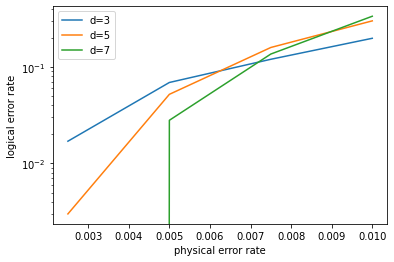

In [22]:
num_shots = 1000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.0025, 0.0050, 0.0075, 0.0100]:
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise)
        xs.append(noise)
        ys.append(count_logical_errors(circuit, num_shots) / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.semilogy()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate")
plt.legend()
plt.show()

You can see from the plot that the threshold of the surface code is somewhere between 0.5% and 1%.
At least, that's the threshold for this specific type of circuit level noise and when using a minimum weight perfect matching decoder (PyMatching).


# End of Tutorial

Congratulations for making it this far! Historically, estimating the threshold of a quantum error correcting code would have taken weeks or months (because you had to write the simulator *and* the matching graph generation *and* the decoder).
By leveraging open source tools, you just did it in a single sitting.
Nicely done!

If you ever run into any problems using Stim, or find yourself confused or misled about how to do something with Stim, please [open an issue at Stim's Github repository](https://github.com/quantumlib/Stim/issues) or [ask a question tagged `Stim` on the quantum computing stack exchange](https://quantumcomputing.stackexchange.com/).
That kind of feedback is **very** helpful and appreciated.

---

If you're looking for an example of a research paper that used Stim to estimate the threshold of a new quantum code, see ["A Fault-Tolerant Honeycomb Memory"](https://arxiv.org/abs/2108.10457) or the [video showing the creation of the initial estimate that eventually led to that paper](https://www.youtube.com/watch?v=E9yj0o1LGII).